In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# API-Endpunkt
url = "https://data.snb.ch/api/cube/plimoinchq/data/json/de"

# Daten abrufen
response = requests.get(url)
data = response.json()

# Daten extrahieren
timeseries = data['timeseries']

# Bundesamt für Statistik - Transaktionspreis auswählen
bfs_series = next(item for item in timeseries if item['header'][1]['dimItem'] == 'Bundesamt für Statistik - Transaktionspreis')

# Werte extrahieren
values = bfs_series['values']
df = pd.DataFrame(values)
df['date'] = pd.PeriodIndex(df['date'], freq='Q').to_timestamp()
df['value'] = df['value'].astype(float)

# DataFrame sortieren
df = df.sort_values('date').reset_index(drop=True)

# Anzeige der ersten Zeilen
df.head()


,date,value
0,2017-01-01,91.1885
1,2017-04-01,91.9562
2,2017-07-01,93.4385
3,2017-10-01,94.1815
4,2018-01-01,94.0386


In [2]:
# Inflationsrate berechnen (jährliche Veränderung)
df['inflation'] = df['value'].pct_change(periods=4)
df['inflation'].fillna(0, inplace=True)

# Anzeige der ersten Zeilen
df.head()


C:\Users\Nevin\AppData\Local\Temp\ipykernel_13276\2065149088.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['inflation'].fillna(0, inplace=True)


,date,value,inflation
0,2017-01-01,91.1885,0.000000
1,2017-04-01,91.9562,0.000000
2,2017-07-01,93.4385,0.000000
3,2017-10-01,94.1815,0.000000
4,2018-01-01,94.0386,0.031255


In [3]:
# Funktion zur Barwertberechnung
def calculate_present_value(future_value, rate, years):
    return future_value / ((1 + rate) ** years)


In [4]:
initial_investment = 500000  # Beispielhafte Anfangsinvestition
time_horizon_years = 10  # Betrachtungszeitraum in Jahren

present_values = []
for i in range(len(df)):
    year = i / 4  # Quartale in Jahre umrechnen
    if year > time_horizon_years:
        break
    fv = initial_investment * (df.loc[i, 'value'] / df.loc[0, 'value'])
    rate = df.loc[i, 'inflation']
    pv = calculate_present_value(fv, rate, year)
    present_values.append({'date': df.loc[i, 'date'], 'present_value': pv})

pv_df = pd.DataFrame(present_values)

# Anzeige der ersten Zeilen
pv_df.head()


,date,present_value
0,2017-01-01,500000.000000
1,2017-04-01,504209.412371
2,2017-07-01,512337.081979
3,2017-10-01,516411.060605
4,2018-01-01,500000.000000


In [5]:
# Funktion zur Amortisationszeitberechnung
def calculate_amortization(initial_investment, cash_flows):
    cumulative = 0
    for i, cash_flow in enumerate(cash_flows):
        cumulative += cash_flow
        if cumulative >= initial_investment:
            return i / 4  # Quartale in Jahre
    return None

# Beispielhafte jährliche Cashflows basierend auf Inflation
cash_flows = [initial_investment * rate for rate in df['inflation'][:len(pv_df)]]
amortization_period = calculate_amortization(initial_investment, cash_flows)

print(f"Amortisationszeit: {amortization_period:.2f} Jahre")


Amortisationszeit: 8.00 Jahre


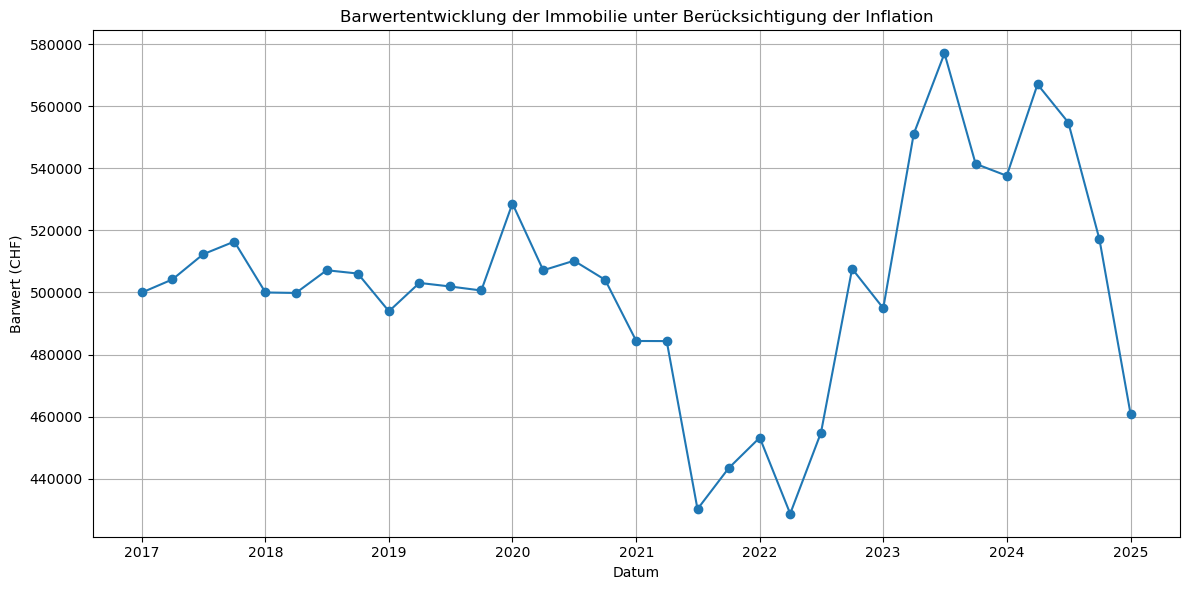

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(pv_df['date'], pv_df['present_value'], marker='o', linestyle='-')
plt.title('Barwertentwicklung der Immobilie unter Berücksichtigung der Inflation')
plt.xlabel('Datum')
plt.ylabel('Barwert (CHF)')
plt.grid(True)
plt.tight_layout()
plt.show()


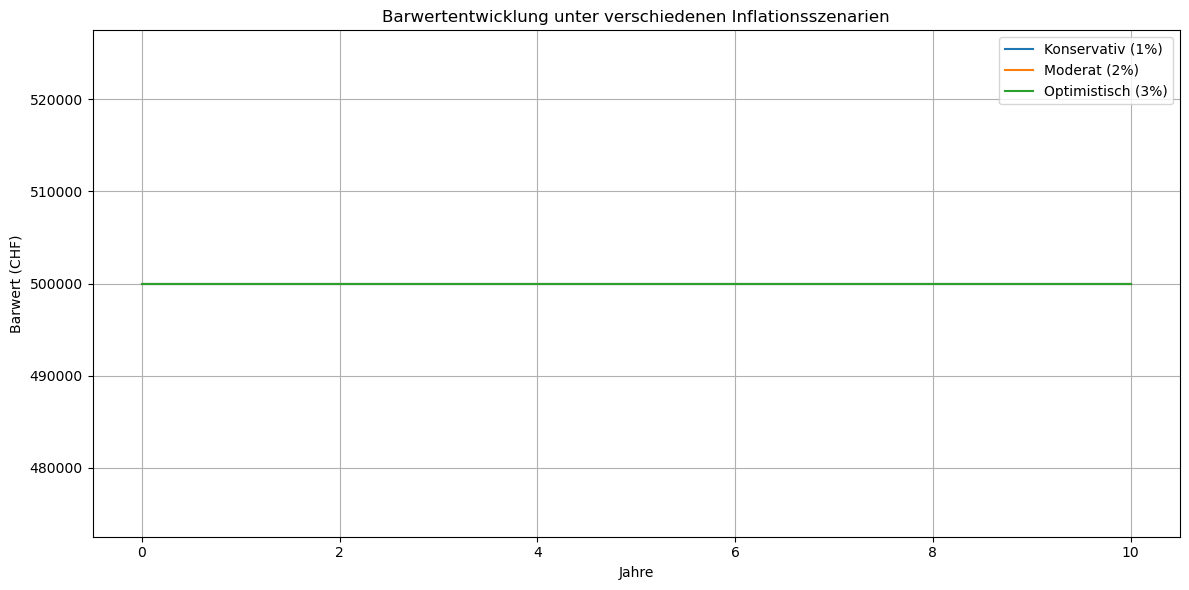

In [7]:
# Verschiedene Inflationsszenarien
scenarios = {
    'Konservativ (1%)': 0.01,
    'Moderat (2%)': 0.02,
    'Optimistisch (3%)': 0.03
}

scenario_pvs = {}
for name, rate in scenarios.items():
    pvs = []
    for year in range(time_horizon_years + 1):
        fv = initial_investment * (1 + rate) ** year
        pv = calculate_present_value(fv, rate, year)
        pvs.append(pv)
    scenario_pvs[name] = pvs

# Visualisierung
plt.figure(figsize=(12, 6))
for name, pvs in scenario_pvs.items():
    plt.plot(range(time_horizon_years + 1), pvs, label=name)

plt.title('Barwertentwicklung unter verschiedenen Inflationsszenarien')
plt.xlabel('Jahre')
plt.ylabel('Barwert (CHF)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
